In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.regularizers import l2

In [26]:
#Load and preprocess data
df_cleaned = pd.read_csv("cleaned_dataset_final.csv")  # Replace with actual dataset

In [27]:
df_cleaned.head()   # Display the first 5 rows of the dataset   

,Unnamed: 0,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,...,cbwd_encoded,cbwd_angle,cbwd_sin,cbwd_cos,pm2.5_rolling_3h,pm2.5_rolling_24h,Iws_lag_1,day_avg_pm2.5,temp_dew_spread,Iws_rain_interaction
0,0,2010,1,1,0,129.0,-21,-11.0,1021.0,1.79,...,1.0,315.0,-0.707107,0.707107,129.0,129.0,1.79,129.0,10.0,0.0
1,1,2010,1,1,1,129.0,-21,-12.0,1020.0,4.92,...,1.0,315.0,-0.707107,0.707107,129.0,129.0,1.79,129.0,9.0,0.0
2,2,2010,1,1,2,129.0,-21,-11.0,1019.0,6.71,...,1.0,315.0,-0.707107,0.707107,129.0,129.0,4.92,129.0,10.0,0.0
3,3,2010,1,1,3,129.0,-21,-14.0,1019.0,9.84,...,1.0,315.0,-0.707107,0.707107,129.0,129.0,6.71,129.0,7.0,0.0
4,4,2010,1,1,4,129.0,-20,-12.0,1018.0,12.97,...,1.0,315.0,-0.707107,0.707107,129.0,129.0,9.84,129.0,8.0,0.0


In [28]:
import pandas as pd

# Load your full dataset
df = df_cleaned  # Replace with your actual dataset path

# Split dataset: last 240 rows for actual_future_data
actual_future_data = df.tail(240).copy()
actual_future_data.rename(columns={'pm2.5': 'actual_pm2.5'}, inplace=True)

# Use the remaining rows for training and testing
train_test_data = df.iloc[:-240].copy()

print(f"Train/Test data size: {train_test_data.shape}")
print(f"Actual Future Data size: {actual_future_data.shape}")

Train/Test data size: (41770, 24)
Actual Future Data size: (240, 24)


In [42]:
train_test_data.tail()

,Unnamed: 0,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,...,cbwd_encoded,cbwd_angle,cbwd_sin,cbwd_cos,pm2.5_rolling_3h,pm2.5_rolling_24h,Iws_lag_1,day_avg_pm2.5,temp_dew_spread,Iws_rain_interaction
41765,43514,2014,12,19,2,248.0,-8,-6.0,1022.0,5.81,...,1.0,315.0,-0.707107,0.707107,258.333333,180.291667,2.68,95.578947,2.0,0.0
41766,43515,2014,12,19,3,219.0,-8,-5.0,1022.0,7.60,...,1.0,315.0,-0.707107,0.707107,240.000000,183.333333,5.81,95.578947,3.0,0.0
41767,43516,2014,12,19,4,199.0,-9,-6.0,1022.0,9.39,...,1.0,315.0,-0.707107,0.707107,222.000000,186.416667,7.60,95.578947,3.0,0.0
41768,43517,2014,12,19,5,198.0,-8,-6.0,1022.0,10.28,...,1.0,315.0,-0.707107,0.707107,205.333333,189.250000,9.39,95.578947,2.0,0.0
41769,43518,2014,12,19,6,204.0,-8,-5.0,1022.0,15.20,...,1.0,315.0,-0.707107,0.707107,200.333333,192.000000,10.28,95.578947,3.0,0.0


In [30]:
actual_future_data.describe()  # Check if the actual_future_data is correct

,Unnamed: 0,year,month,day,hour,actual_pm2.5,DEWP,TEMP,PRES,Iws,...,cbwd_encoded,cbwd_angle,cbwd_sin,cbwd_cos,pm2.5_rolling_3h,pm2.5_rolling_24h,Iws_lag_1,day_avg_pm2.5,temp_dew_spread,Iws_rain_interaction
count,240.000000,240.0,240.0,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,...,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.0
mean,43684.100000,2014.0,12.0,25.691667,11.500000,107.145833,-12.779167,0.083333,1024.666667,16.956417,...,1.695833,229.500000,-0.182669,0.477297,107.952778,116.239063,16.477792,111.003947,12.862500,0.0
std,74.022885,0.0,0.0,3.105659,6.936653,101.272859,2.793669,4.922127,6.392115,26.073646,...,1.091611,114.879234,0.684532,0.522806,98.936340,74.792755,25.021663,73.980831,6.277563,0.0
min,43519.000000,2014.0,12.0,19.000000,0.000000,7.000000,-23.000000,-9.000000,1011.000000,0.450000,...,1.000000,45.000000,-0.707107,-0.707107,8.333333,13.958333,0.450000,10.714286,3.000000,0.0
25%,43626.750000,2014.0,12.0,23.000000,5.750000,20.000000,-14.000000,-4.000000,1020.000000,1.790000,...,1.000000,135.000000,-0.707107,0.707107,19.583333,57.114583,1.790000,45.962500,7.000000,0.0
50%,43686.500000,2014.0,12.0,26.000000,11.500000,80.000000,-13.000000,-0.500000,1024.000000,5.800000,...,1.000000,315.000000,-0.707107,0.707107,82.166667,103.354167,5.800000,98.726974,12.000000,0.0
75%,43746.250000,2014.0,12.0,28.000000,17.250000,162.250000,-11.000000,4.000000,1030.250000,19.340000,...,2.000000,315.000000,0.707107,0.707107,156.166667,180.375000,18.217500,170.250000,18.250000,0.0
max,43806.000000,2014.0,12.0,31.000000,23.000000,444.000000,-7.000000,11.000000,1035.000000,130.070000,...,4.000000,315.000000,0.707107,0.707107,408.333333,284.541667,129.640000,238.666667,29.000000,0.0


In [31]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler and fit it on the train/test dataset (excluding datetime)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train_test_data.drop(['datetime'], axis=1))

# Convert scaled data back to a DataFrame
scaled_train_test_data = pd.DataFrame(scaled_data, columns=train_test_data.columns[1:])  # Keep column names

In [32]:
import numpy as np

# Function to create sequences for LSTM
def create_sequences(data, target_column, time_steps=72):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:i + time_steps].values)
        y.append(data.iloc[i + time_steps][target_column])
    return np.array(X), np.array(y)

# Create sequences for training and testing
time_steps = 72
X, y = create_sequences(scaled_train_test_data, target_column='pm2.5', time_steps=time_steps)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (33358, 72, 23), y_train shape: (33358,)
X_test shape: (8340, 72, 23), y_test shape: (8340,)


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Build the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(time_steps, X_train.shape[2])),
    Dropout(0.3),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)  # Single output for PM2.5
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=12, batch_size=32, callbacks=[early_stopping])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 72, 128)        │        77,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 72, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        91,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,525 (681.74 KB)

 Trainable params: 174,525 (681.74 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 53s 49ms/step - loss: 0.0451 - mae: 0.1382 - val_loss: 0.0074 - val_mae: 0.0460
Epoch 2/12
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 51s 49ms/step - loss: 0.0178 - mae: 0.0677 - val_loss: 0.0061 - val_mae: 0.0298
Epoch 3/12
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 53s 51ms/step - loss: 0.0122 - mae: 0.0520 - val_loss: 0.0045 - val_mae: 0.0243
Epoch 4/12
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 51s 49ms/step - loss: 0.0091 - mae: 0.0430 - val_loss: 0.0027 - val_mae: 0.0216
Epoch 5/12
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 52s 49ms/step - loss: 0.0096 - mae: 0.0444 - val_loss: 0.0040 - val_mae: 0.0216
Epoch 6/12
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 51s 49ms/step - loss: 0.0077 - mae: 0.0381 - val_loss: 0.0033 - val_mae: 0.0247
Epoch 7/12
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 51s 49ms/step - loss: 0.0053 - mae: 0.0308 - val_loss: 0.0039 - val_mae: 0.0364
Epoch 8/12
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 51s 49ms/step - loss: 0.0057 - mae: 0.0304 - val_loss: 0.0044 - val_mae: 0.0253
Epoch 9/12
1043/1043 ━━━

In [46]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0020 - mae: 0.0134
Test Loss: 0.0021, Test MAE: 0.0135


In [47]:
# Start with the last sequence from X_test
future_sequence = X_test[-1].reshape(1, time_steps, X_test.shape[2])

# Placeholder for future predictions
future_predictions = []

# Iteratively predict the next 240 steps
for step in range(240):
    next_pred = model.predict(future_sequence)  # Predict the next PM2.5 value
    future_predictions.append(next_pred[0, 0])  # Store the prediction
    
    # Update the sequence
    next_pred_full = future_sequence[:, -1:, :].copy()  # Copy the last time step
    next_pred_full[0, 0, -1] = next_pred[0, 0]  # Replace only the PM2.5 feature with the prediction
    future_sequence = np.append(future_sequence[:, 1:, :], next_pred_full, axis=1)  # Append the new step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

In [48]:
# Convert predicted PM2.5 values back to the original scale
future_predictions_actual = scaler.inverse_transform(
    np.column_stack([np.zeros((len(future_predictions), X_test.shape[2] - 1)), future_predictions])
)[:, -1]

In [49]:
from datetime import timedelta

# Generate future timestamps for 240 steps (hourly)
last_datetime = pd.to_datetime("2014-12-19 06:00:00")  # Replace with actual last datetime
future_timestamps = [last_datetime + timedelta(hours=i+1) for i in range(240)]

# Create DataFrame with future predictions
future_pm25_df = pd.DataFrame({
    'datetime': future_timestamps,
    'predicted_pm2.5': future_predictions_actual
})

# Save to CSV
future_pm25_df.to_csv("future_pm25_prediction.csv", index=False)
print("Future predictions saved to future_pm25_prediction.csv")

Future predictions saved to future_pm25_prediction.csv


In [50]:
# Merge future predictions with actual future data
comparison_df = pd.merge(future_pm25_df, actual_future_data, on='datetime', how='inner')

# Calculate MAE and RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(comparison_df['actual_pm2.5'], comparison_df['predicted_pm2.5'])
rmse = np.sqrt(mean_squared_error(comparison_df['actual_pm2.5'], comparison_df['predicted_pm2.5']))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 1014.65
Root Mean Squared Error (RMSE): 1021.07


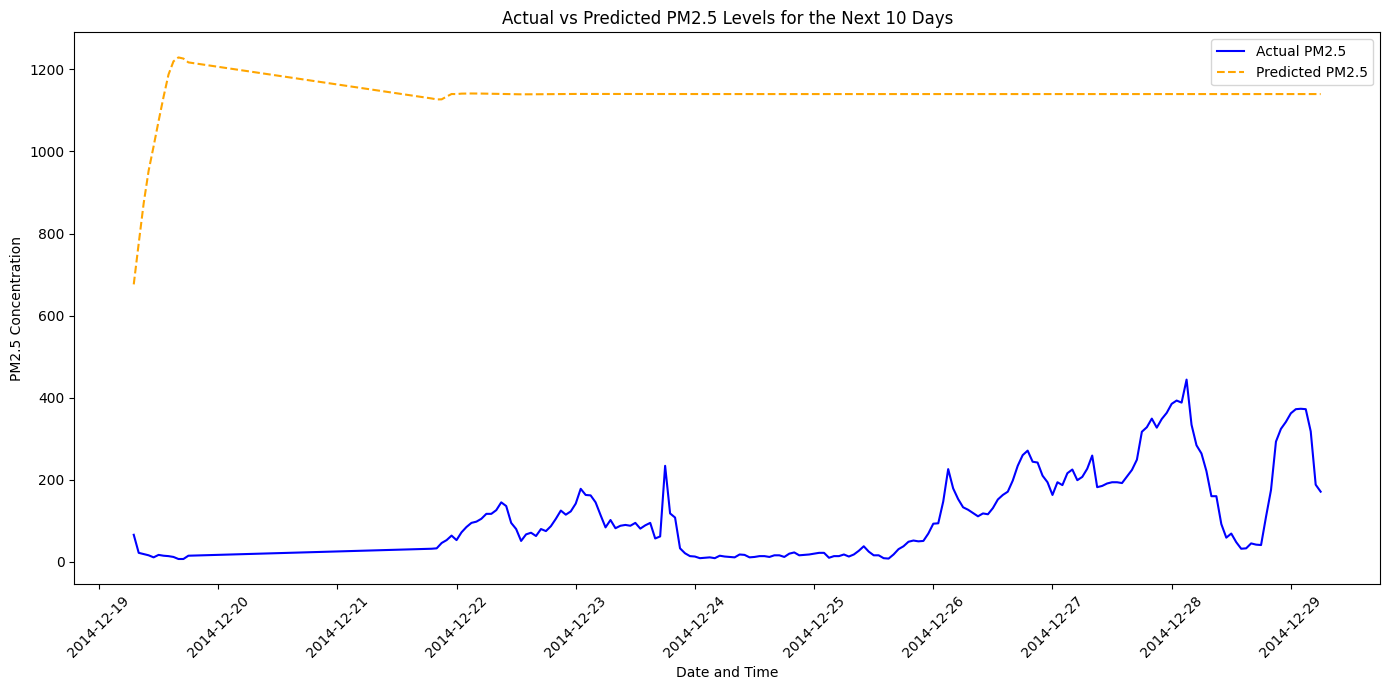

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(comparison_df['datetime'], comparison_df['actual_pm2.5'], label='Actual PM2.5', color='blue')
plt.plot(comparison_df['datetime'], comparison_df['predicted_pm2.5'], label='Predicted PM2.5', color='orange', linestyle='dashed')
plt.title('Actual vs Predicted PM2.5 Levels for the Next 10 Days')
plt.xlabel('Date and Time')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()